In [1]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Categorical
import math
import torch.nn as nn

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(env.observation_space.shape, obs_dim, action_dim)

(4,) 4 2


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(QNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

In [4]:
Q_pi = QNetwork(obs_dim, action_dim).to(device)
def select_action(state, is_test = False):
    action_probs = Q_pi(torch.FloatTensor(state).to(device))
    # 得到动作策略的概率质量分布,用该分布初始化采样器
    m = Categorical(action_probs)
    # 按该分布做采样,得到一个动作
    action = m.sample().item()
    # 对概率质量函数取对数,并采样该分布在action的值,即log P在action点的概率密度函数值
    loss = m.log_prob(action)
    return action, loss

In [6]:
gamma = 0.98

optimizer = optim.Adam(Q_pi.parameters(), lr=0.0001)
steps = []
scores = []
max_epoch = 1000
for i in range(max_epoch):
    score = 0
    step = 0
    u_t = 0
    
    state, _ = env.reset(seed=3)
    trajectories = []
    while True:
        action, loss = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        step += 1
        score += reward
        trajectories.append([state, action, reward, loss])
        if done or step > 200:
            steps.append(step)
            scores.append(score)
            break
            
        state = next_state
    # 一轮结束,开始训练
    L = len(trajectories)
    for t in range(L):
        item = trajectories[t]
        u_t = sum([loc[2] * gamma ** i for i, loc in enumerate(trajectories[t:])])
        
        optimizer.zero_grad()
        probs = Q_pi(item[0])
        m = Categorical(probs)
        loss = -u_t * m.log_prob(item[1])
        loss.backward()
        optimizer.step()
        

NameError: name 'Categorical' is not defined

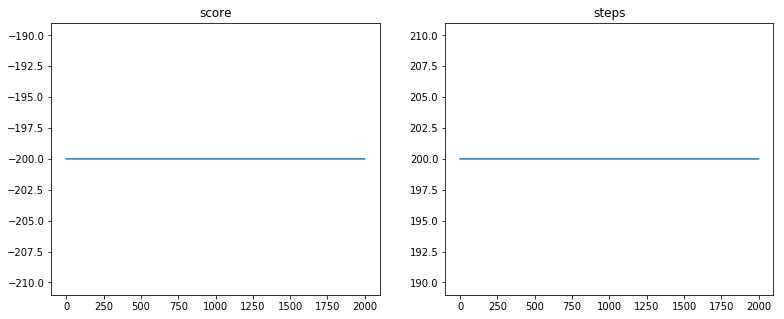

In [6]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
# plt.subplot(133)
# plt.title('epsilons')
# plt.plot(epsilons)
plt.show()

In [ ]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=seed)
    done = False
    score = 0
    step = 0
    while not done and step < 200:
        action = select_action(state, False)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()